# Causal Influence Decomposition of the Human Brain Using Multi-site In-silico Perturbation Analysis


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import warnings
import scipy
import networkx as nx
import seaborn as sns
import utils as ut
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from tqdm import tqdm
from msapy import msa

from IPython.display import HTML

from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform, cosine
from scipy.special import factorial

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression, LassoCV

from sklearn.metrics import r2_score
from netneurotools.metrics import communicability_wei, communicability_bin, distance_wei_floyd

from visual_config import *
from matplotlib import font_manager


for font in font_manager.findSystemFonts('figures/Atkinson_Typeface/'):
    font_manager.fontManager.addfont(font)


In [3]:
import session_info
session_info.show()


In [4]:
SEED = 2023

sagittal = (0, 180)
axial = (90, 180)
coronal = (0, 90)
bottom = (-90, 0)
scatter_kw = dict(alpha=1, linewidths=0.7, edgecolors=HALF_BLACK)
size = 80


In [5]:
set_visual_style()

In [6]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = ut.spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = ut.spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = ut.event_maker(6,timesteps)


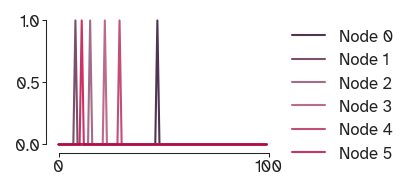

In [7]:
plt.figure(figsize=TINY,dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'],bbox_to_anchor=(1, 1),frameon=False);
plt.xticks([0,timesteps])

sns.despine(offset=1, trim=True);


In [8]:
NOISE_STRENGTH = 0.1
DELTA = 0.01
TAU = 0.02
G =0.74
DURATION = 1
model_params = {'dt':DELTA,'timeconstant':TAU,'coupling':G,'duration':DURATION}

In [9]:
warnings.filterwarnings("ignore")

simple_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=chain,
                                                              input_matrix=example_input,
                                                                 **model_params)
closed_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=closedchain,
                                                              input_matrix=example_input,
                                                                 **model_params)
symmetric_chain_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=symmetricchain,
                                                                 input_matrix=example_input,
                                                                 **model_params)

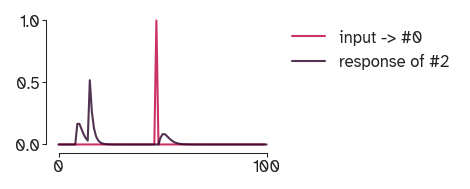

In [10]:
plt.figure(figsize=TINY,dpi=150)

plt.plot(example_input[0],alpha=0.8,color=RED)
plt.plot(simple_chain_dynamics[2],alpha=0.8,color=PURPLEST)

plt.legend(['input -> #0','response of #2'],bbox_to_anchor=(1, 1),frameon=False);
plt.xticks([0,DURATION/DELTA])
sns.despine(offset=1, trim=True);


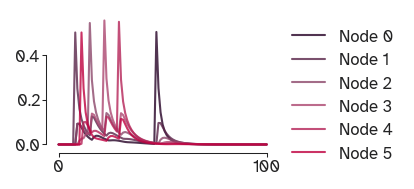

In [11]:
plt.figure(figsize=TINY,dpi=150)
with sns.color_palette(purple_red,n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'],bbox_to_anchor=(1, 1),frameon=False);
plt.xticks([0,DURATION/DELTA])
sns.despine(offset=1, trim=True);


In [12]:
cchain = communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain = communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain = communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [13]:
lesion_params = {'adjacency_matrix': chain, 'input': example_input, 'model_kwargs': model_params}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['adjacency_matrix'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=ut.lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]

Doing Nodes:  33%|███▎      | 2/6 [00:01<00:01,  2.08it/s]

Doing Nodes:  50%|█████     | 3/6 [00:01<00:00,  3.12it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  4.24it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  5.31it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:01,  2.69it/s]

Doing Nodes:  50%|█████     | 3/6 [00:00<00:00,  3.99it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:01<00:00,  5.19it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:01<00:00,  6.21it/s]

Doing Nodes:   0%|          | 0/6 [00:00<?, ?it/s]

Doing Nodes:  17%|█▋        | 1/6 [00:00<00:00,  7.81it/s]

Doing Nodes:  33%|███▎      | 2/6 [00:00<00:00,  8.10it/s]

Doing Nodes:  50%|█████     | 3/6 [00:00<00:00,  8.78it/s]

Doing Nodes:  67%|██████▋   | 4/6 [00:00<00:00,  8.39it/s]

Doing Nodes:  83%|████████▎ | 5/6 [00:00<00:00,  8.23it/s]

Doing Nodes: 100%|██████████| 6/6 [00:00<00:00,  8.40it/s]


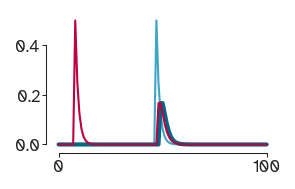

In [14]:
plt.figure(figsize=TINY,dpi=150)
plt.plot(simple_chain_dynamics[0],color=BLUE)
plt.plot(ci_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(simple_chain_dynamics[1],color=RED);
plt.xticks([0,DURATION/DELTA])

sns.despine(offset=1, trim=True);


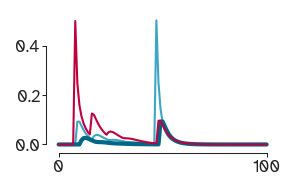

In [15]:
plt.figure(figsize=TINY,dpi=150)
plt.plot(symmetric_chain_dynamics[0],color=BLUE)
plt.plot(ci_symmetric_chain[0][1],color=DEEP_BLUE,linewidth=2) #influence of 0 on 1
plt.plot(symmetric_chain_dynamics[1],color=RED);
plt.xticks([0,DURATION/DELTA])

sns.despine(offset=1, trim=True);


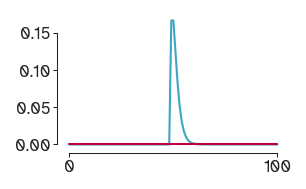

In [16]:
plt.figure(figsize=TINY,dpi=150)
plt.plot(ci_chain[0][1],color=BLUE) #influence of 0 on 1
plt.plot(ci_chain[1][0],color=RED); #influence of 1 on 0
plt.xticks([0,DURATION/DELTA])

sns.despine(offset=1, trim=True);


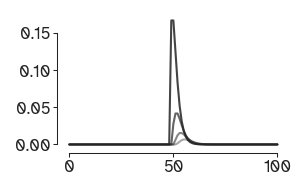

In [17]:
plt.figure(figsize=TINY,dpi=150)
for i in range(5):
    plt.plot(ci_chain[0][i],color=HALF_BLACK,alpha=1-i*0.15) #influence of 0 over the rest
sns.despine(offset=1, trim=True);


In [18]:
example_modes = ci_symmetric_chain.values.reshape(6,101,6)

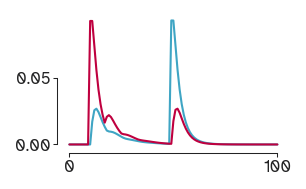

In [19]:
plt.figure(figsize=TINY,dpi=150)

plt.plot(example_modes[1,:,0],color=BLUE) #influence of 0 on 1
plt.plot(example_modes[0,:,1],color=RED); #influence of 1 on 0
plt.xticks([0,DURATION/DELTA])

sns.despine(offset=1, trim=True);


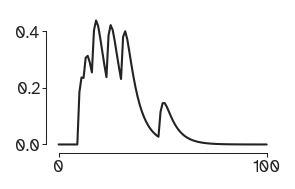

In [20]:
plt.figure(figsize=TINY,dpi=150)
plt.plot(np.nan_to_num(example_modes).sum(axis=0).sum(axis=1),color=HALF_BLACK);
plt.xticks([0,DURATION/DELTA])

sns.despine(offset=1, trim=True);


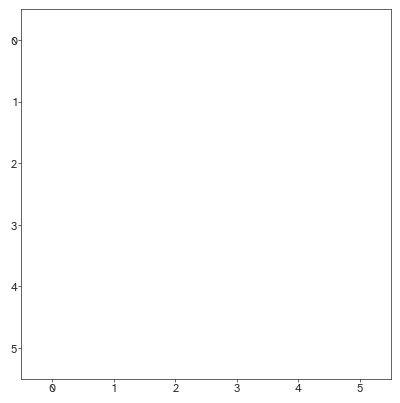

In [21]:
fig, ax = plt.subplots()
heatmaps = [[plt.imshow(example_modes[:,i,:],cmap=white_red_mono,animated=True,vmin=0, vmax=np.nan_to_num(example_modes).max())] for i in range(101)]
anim = animation.ArtistAnimation(fig, heatmaps, interval=60,blit=True)
HTML(anim.to_jshtml())


In [22]:
# f = r"example_causal_contributions.gif" 
# writergif = animation.PillowWriter(fps=30) 
# anim.save(f, writer=writergif)

In [23]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

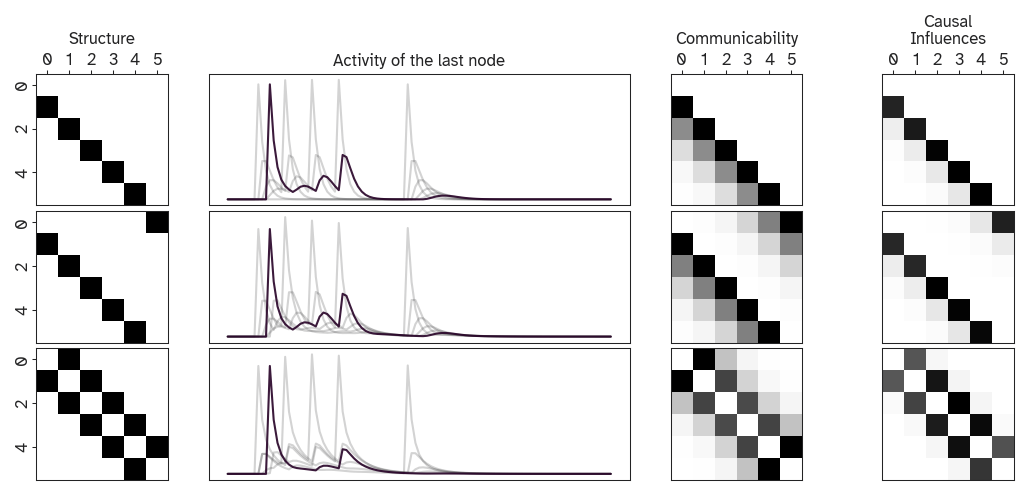

In [24]:
fig,axes = plt.subplot_mosaic([['X','B', 'B','CX','CIX'],
                               ['Y','D', 'D','CY','CIY'],
                               ['Z','F', 'F','CZ','CIZ']],figsize=(18*CM,8*CM),dpi=150)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'], linecolor=HALF_BLACK)

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'], linecolor=HALF_BLACK)

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'], linecolor=HALF_BLACK)
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'], linecolor=HALF_BLACK)

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'], linecolor=HALF_BLACK)

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'], linecolor=HALF_BLACK)
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'], linecolor=HALF_BLACK)

sns.heatmap(ci_closed_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'], linecolor=HALF_BLACK)

sns.heatmap(ci_symmetric_chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'], linecolor=HALF_BLACK)

for ax in ['B','D','F']:

    axes[ax].yaxis.set_visible(False)

for ax in ['B','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=HALF_BLACK,alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=HALF_BLACK,alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=HALF_BLACK,alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=PURPLEST,alpha=(0.9))

axes['B'].set_title('Activity of the last node',fontsize=8)
axes['X'].set_title('Structure',fontsize=8)
axes['CX'].set_title('Communicability',fontsize=8)
axes['CIX'].set_title('Causal\nInfluences',fontsize=8)

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.1)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [25]:
res_parcellation = 2 # zero is low res, two is high res
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][res_parcellation][0])
fc = consensus_mat['LauConsensus']['Matrices'][res_parcellation][2]
fiber_lengths = consensus_mat['LauConsensus']['Matrices'][res_parcellation][1]
coordinates = consensus_mat['LauConsensus']['Matrices'][res_parcellation][3]
labels = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,0]
fc_modules = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,2]


PearsonRResult(statistic=0.23272827255420686, pvalue=0.0)


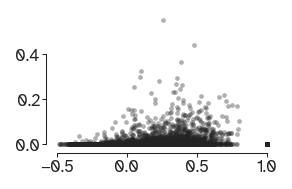

In [26]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(x=fc.flatten(),y=connectivity.flatten(),color=HALF_BLACK,s=5,linewidth=0,alpha=0.2)

sns.despine(offset=1, trim=True);

print(pearsonr(fc.flatten(),connectivity.flatten()))

In [27]:
ut.check_symmetric(connectivity)

True

In [28]:
N_NODES = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)

In [29]:
rng = np.random.default_rng(seed=SEED)
input_noise = rng.normal(0, 2, (N_NODES, int(DURATION/DELTA)+1)) # 2 for tanh and 0.5 for linear
simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                                              input_matrix=input_noise,
                                                              function=ut.tanh,
                                                              **model_params)


([], [])

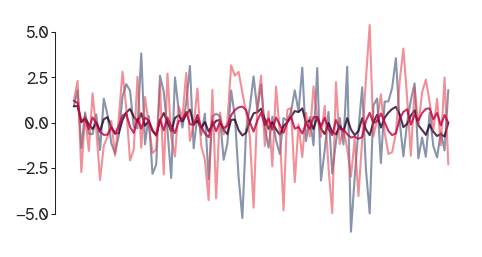

In [30]:
plt.figure(figsize=SMALL,dpi=150)
plt.plot(input_noise[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[-1],alpha=0.8,color=PURPLEST)
plt.plot(input_noise[0],alpha=0.6,color=ORANGE)
plt.plot(simple_human_dynamics[0],alpha=0.8,color=RED);
sns.despine(offset=0, trim=True,bottom=True);
plt.xticks([])

#plt.savefig(f"figures/tanh_example_activity.pdf",dpi=600,bbox_inches='tight')

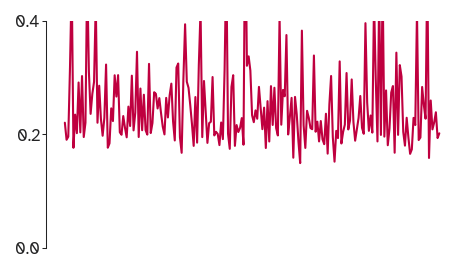

In [31]:
plt.figure(figsize=SMALL,dpi=150)
plt.plot(simple_human_dynamics.var(axis=1),color = RED)
plt.plot(input_noise.var(axis=1),alpha=0.6,color=NIGHT_BLUE);
plt.xticks([])
plt.ylim(0,0.4)
plt.yticks([0,0.2,0.4])
sns.despine(offset=0, trim=True,bottom=True);


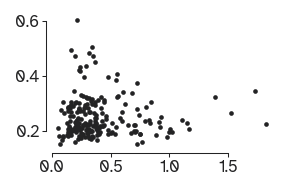

In [32]:
plt.figure(figsize=TINY,dpi=150)

sns.scatterplot(x=connectivity.sum(axis=0),y=simple_human_dynamics.var(axis=1),color=HALF_BLACK,s=5,linewidth=0);
sns.despine(offset=1, trim=True);


In [33]:
N_TRIALS = 10
all_trials = np.zeros((len(connectivity),len(connectivity),N_TRIALS))

In [34]:
nonlinear = False
if nonlinear:
    for trial in range(N_TRIALS):
        temp = pd.read_pickle(f'results/nonlinear_weighted/causal_modes_nl_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).var().fillna(0)
        all_trials[:,:,trial] = temp
    
    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)
    
else:
    for trial in range(N_TRIALS):
        temp = pd.read_pickle(f'results/linear_weighted/causal_modes_l_w_{len(connectivity)}_{trial}.pickle').groupby(level=0).var().fillna(0)
        all_trials[:,:,trial] = temp
    
    averaged_ci = all_trials.mean(axis=2)
    averaged_ci = pd.DataFrame(averaged_ci)

if res_parcellation == 0:
    averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_68_0.pickle').groupby(level=0).var().fillna(0)


In [35]:
HOPF = False
if HOPF:
    #averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_219_no_delay_longer_T.pickle')
    averaged_ci = pd.read_pickle(f'results/causal_modes_hopf_219_T5.pickle')

    hopf_modes = averaged_ci.values.reshape(219,5000,219)
    #hopf_modes = averaged_ci.values.reshape(219,101,219)

    sliced_modes = hopf_modes[:,1000:,:]
    #sliced_modes = hopf_modes
    averaged_ci = pd.DataFrame(np.nan_to_num(sliced_modes).var(axis=1))


In [36]:
ut.check_symmetric(averaged_ci)

False

In [37]:
diffusion_efficiency = pd.read_csv('results/communication_models/com_mat_DE.txt',header=None)
navigation_efficiency = pd.read_csv('results/communication_models/com_mat_NE.txt',header=None)
search_information = pd.read_csv('results/communication_models/com_mat_SI.txt',header=None)
shortest_path_efficiency = pd.read_csv('results/communication_models/com_mat_SPE.txt',header=None)

In [38]:
lognorm_ci = ut.minmax_normalize(ut.log_normalize(averaged_ci))
np.fill_diagonal(lognorm_ci,0.)

lognorm_comm = ut.minmax_normalize(ut.log_normalize(communicability_wei(connectivity)))
np.fill_diagonal(lognorm_comm,0.)

lognorm_sc = ut.minmax_normalize(ut.log_normalize(connectivity))
np.fill_diagonal(lognorm_sc,0.)
lognorm_sc = np.where(lognorm_sc!=1,lognorm_sc,0)
difference = lognorm_ci-lognorm_comm

scaler = StandardScaler()
difference = scaler.fit_transform(difference)
np.fill_diagonal(difference,0.)

difference_outgoing = ut.make_influence_ratio(difference,axis=0)
difference_incoming = ut.make_influence_ratio(difference,axis=1)

difference_direct = pd.DataFrame(difference).where(connectivity!=0)
difference_indirect = pd.DataFrame(difference).where(connectivity==0)

direct_influence = pd.DataFrame(lognorm_ci).where(connectivity!=0)
indirect_influence = pd.DataFrame(lognorm_ci).where(connectivity==0)

PearsonRResult(statistic=0.7715768228077934, pvalue=0.0)


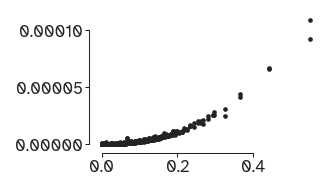

In [39]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(x=connectivity.flatten(),y=averaged_ci.values.flatten(),color=HALF_BLACK,s=5,linewidth=0);
sns.despine(offset=1, trim=True);

print(pearsonr(connectivity.flatten(),averaged_ci.values.flatten()))

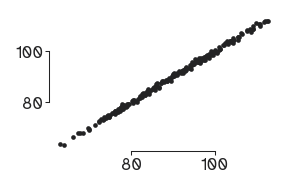

In [40]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(x=lognorm_ci.sum(axis=0),y=lognorm_ci.sum(axis=1),s=5,color=HALF_BLACK,linewidth=0)
sns.despine(offset=0, trim=True);


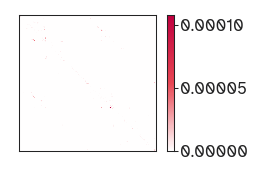

In [41]:
plt.figure(figsize=TINY,dpi=150)

sns.heatmap(averaged_ci,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,linewidths=0, center=0, linecolor=HALF_BLACK)
sns.despine(top=False, right=False, left=False, bottom=False);

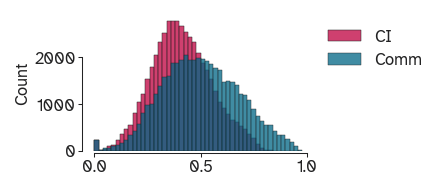

In [42]:
plt.figure(figsize=TINY,dpi=150)
sns.histplot(lognorm_ci.flatten(),binwidth=0.02,color=RED)
sns.histplot(lognorm_comm.flatten(),binwidth=0.02,color=DEEP_BLUE);
sns.despine(offset=1, trim=True);
plt.legend(['CI','Comm'],bbox_to_anchor=(1, 1), loc=2, frameon=False);
#plt.savefig(f"figures/tanh_CI_CO_hist.pdf",dpi=600,bbox_inches='tight')

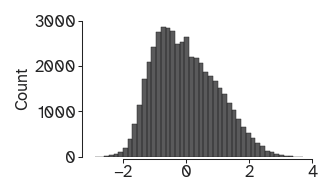

In [43]:
plt.figure(figsize=TINY,dpi=150)
sns.histplot(difference.flatten(),binwidth=0.15,color=HALF_BLACK)
sns.despine(offset=1, trim=True);
#plt.savefig(f"figures/tanh_CI_CO_diff_hist.pdf",dpi=600,bbox_inches='tight')

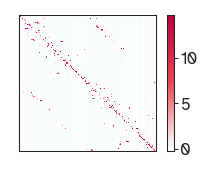

In [44]:
plt.figure(figsize=TINY,dpi=150)

sns.heatmap(scipy.stats.zscore(averaged_ci),square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,linewidths=0, center=0, linecolor=HALF_BLACK)
sns.despine(top=False, right=False, left=False, bottom=False);

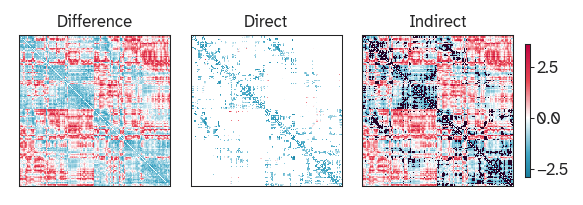

In [45]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=SMALL,dpi=150)
cbar_ax = fig.add_axes([.99, 0.275, .01, 0.45])

sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,cbar=False,ax=axes['A'],linewidths=0,center=0, linecolor=HALF_BLACK)

sns.heatmap(difference_direct,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=diverge_from_white,cbar=False,ax=axes['B'],linewidths=0,linecolor=HALF_BLACK)

sns.heatmap(difference_indirect,square=True,xticklabels=False,yticklabels=False, 
            cmap=diverge_from_white,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, center=0, linecolor=HALF_BLACK)

sns.despine(fig=fig,top=False, right=False, left=False, bottom=False);

axes['A'].title.set_text('Difference')
axes['B'].title.set_text('Direct')
axes['C'].title.set_text('Indirect')
axes['C'].set_facecolor(PURPLEST)
fig.tight_layout(pad=1)

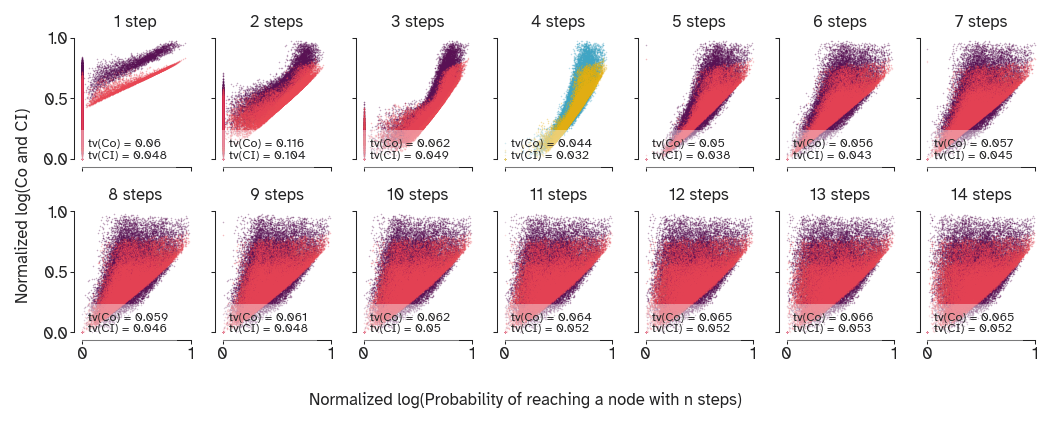

In [46]:
fig,axes = plt.subplots(ncols=7,nrows=2,figsize=HALF_PAGE,sharey='row',sharex='col',dpi=150)

for path,axis in enumerate(axes.ravel()):
    w = np.linalg.matrix_power(connectivity,path+1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w,0.)
    w = np.where(w!=1,w,0)
    total_variance_comm = round(w.var()+lognorm_comm.var(),3)
    total_variance_ci = round(w.var()+lognorm_ci.var(),3)

    if path==3:
        sns.scatterplot(x=w.flatten(),y=lognorm_comm.flatten(),s=0.5,linewidth=0,alpha=0.2,color=BLUE,ax=axis,rasterized=True)
        sns.scatterplot(x=w.flatten(),y=lognorm_ci.flatten(),s=0.5,linewidth=0,alpha=0.2,color=YELLOW,ax=axis,rasterized=True)
        sns.despine()

    else:
        sns.scatterplot(x=w.flatten(),y=lognorm_comm.flatten(),s=0.5,linewidth=0,alpha=0.2,color=PURPLER,ax=axis,rasterized=True)
        sns.scatterplot(x=w.flatten(),y=lognorm_ci.flatten(),s=0.5,linewidth=0,alpha=0.2,color=ORANGE,ax=axis,rasterized=True)
        sns.despine()

        
    if path==0:
        axis.set_title(f'{path+1} step',fontsize=8)
    else:
        axis.set_title(f'{path+1} steps',fontsize=8)
    axis.annotate(f'tv(Co) = {total_variance_comm}\ntv(CI) = {total_variance_ci}', 
              xy=(0.1, 0.05),fontsize=6, xycoords='axes fraction',bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))


fig.supxlabel('Normalized log(Probability of reaching a node with n steps)',fontsize=8)
fig.supylabel('Normalized log(Co and CI)',fontsize=8)

sns.despine(offset=1, trim=True);   
fig.tight_layout(pad=1)
#plt.savefig(f"figures/tanh_scatter_step_by_steps.pdf",dpi=600,bbox_inches='tight')

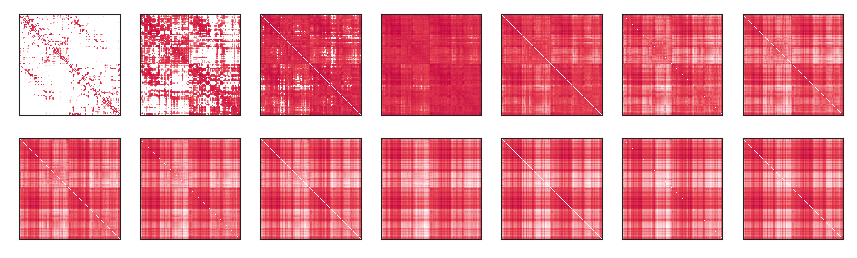

In [47]:
fig,axes = plt.subplots(ncols=7,nrows=2,figsize=(18*CM,5*CM),sharey='row',sharex='col',dpi=150)

for path,axis in enumerate(axes.ravel()):
    w = np.linalg.matrix_power(connectivity,path+1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w,0.)
    w = np.where(w!=1,w,0)
    sns.heatmap(w,square=True,xticklabels=False,yticklabels=False,cmap=white_red_mono,cbar=False,ax=axis,linewidths=0, linecolor=HALF_BLACK,rasterized=True)
sns.despine(fig=fig,top=False, right=False, left=False, bottom=False);
#plt.savefig(f"figures/heatmap_step_by_steps.pdf",dpi=600,bbox_inches='tight')

In [48]:
graph_distance = -np.log10(connectivity.copy(order='C'))
shortest_path_distance,_ = distance_wei_floyd(np.abs(graph_distance))

In [49]:
pd.DataFrame({'sp':shortest_path_distance[0],
              'sc':connectivity[0]}).head(50)

sp        sc
0   0.000000  0.000000
1   1.410852  0.038828
2   0.961313  0.109317
3   1.424446  0.037632
4   2.642278  0.000198
5   3.633832  0.000000
6   2.044944  0.009017
7   1.630775  0.023400
8   2.741469  0.001814
9   2.230999  0.000000
10  3.356689  0.000000
11  3.010694  0.000000
12  4.463959  0.000000
13  5.008866  0.000000
14  4.818581  0.000000
15  4.933860  0.000000
16  4.047432  0.000000
17  3.778946  0.000000
18  2.809095  0.000341
19  3.508401  0.000000
20  4.286827  0.000000
21  3.890337  0.000000
22  3.885725  0.000000
23  4.275283  0.000000
24  4.825843  0.000000
25  5.388162  0.000000
26  4.633000  0.000000
27  5.933091  0.000000
28  5.075666  0.000000
29  4.229494  0.000000
30  4.202736  0.000000
31  4.893927  0.000000
32  5.991995  0.000000
33  6.173399  0.000000
34  5.923266  0.000000
35  5.827488  0.000000
36  5.867842  0.000000
37  5.897840  0.000000
38  6.025826  0.000000
39  3.073797  0.000000
40  3.934000  0.000000
41  5.027740  0.000000
42  5.500083  0.000000
43  5.454317  0.000000
44  3.827122  0.000000
45  5.568673  0.000000
46  5.853862  0.000000
47  4.421724  0.000000
48  4.106945  0.000000
49  5.817934  0.000000

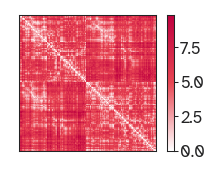

In [50]:
plt.figure(figsize=TINY,dpi=150)

sns.heatmap(shortest_path_distance,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar=True,linewidths=0,linecolor=HALF_BLACK,rasterized=True)
sns.despine(top=False, right=False, left=False, bottom=False);
#plt.savefig(f"figures/shortest_path_distance_matrix.pdf",dpi=600,bbox_inches='tight')

In [51]:
if HOPF:
    fig,axes = plt.subplot_mosaic([['A','B']],figsize=(9*CM,3*CM),dpi=150)
    #influence of [this, :, over this]

    # 0: lateralorbitofrontal
    # 2: lateralorbitofrontal
    # 6: medialorbitofrontal
    # 20: superiorfrontal

    # 9: pars triangularis
    # 44: postcentral
    axes['A'].plot(sliced_modes[0,:,2],color=NIGHT_BLUE)
    axes['A'].plot(sliced_modes[0,:,6],color=NIGHT_BLUE,alpha=0.7)
    axes['A'].plot(sliced_modes[0,:,20],color=PURPLE)


    axes['B'].plot(sliced_modes[0,:,9],color=PURPLE)
    axes['B'].plot(sliced_modes[0,:,44],color=PURPLE,alpha=0.7)
    axes['B'].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    fig.tight_layout(pad=0.1)
    plt.savefig(f"figures/HOPF_example_modes.pdf",dpi=600,bbox_inches='tight')

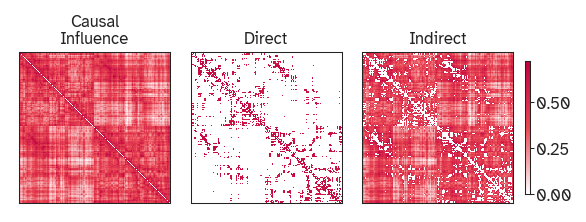

In [52]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=SMALL,dpi=150)
cbar_ax = fig.add_axes([.99, 0.275, .01, 0.45])

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['A'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)

sns.heatmap(direct_influence,square=True,xticklabels=False,yticklabels=False,center=0, 
            cmap=white_red_mono,cbar=False,ax=axes['B'],linewidths=0,linecolor=HALF_BLACK,rasterized=True)

sns.heatmap(indirect_influence,square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,cbar_ax=cbar_ax,ax=axes['C'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)
sns.despine(fig=fig,top=False, right=False, left=False, bottom=False);

axes['A'].title.set_text('Causal\nInfluence')
axes['B'].title.set_text('Direct')
axes['C'].title.set_text('Indirect')
axes['C'].set_facecolor(WHITE)
fig.tight_layout(pad=1)
#plt.savefig(f"figures/tanh_causal_influences.pdf",dpi=600,bbox_inches='tight')

In [53]:
indirect_influence.fillna(0,inplace=True)
direct_influence.fillna(0,inplace=True)

indirect_sender_receiver_ratio = pd.DataFrame(data=np.array(indirect_influence.sum(axis=0)/indirect_influence.sum(axis=1)),index=labels)
direct_sender_receiver_ratio = pd.DataFrame(data=np.array(direct_influence.sum(axis=0)/direct_influence.sum(axis=1)),index=labels)

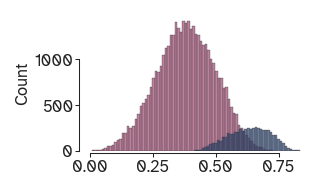

In [54]:
plt.figure(figsize=TINY,dpi=150)
sns.histplot(data=indirect_influence.values.flatten()[indirect_influence.values.flatten()!=0],binwidth=0.01,color=PURPLE)
sns.histplot(data=direct_influence.values.flatten()[direct_influence.values.flatten()!=0],binwidth=0.01,color=NIGHT_BLUE)
sns.despine(offset=1, trim=True);


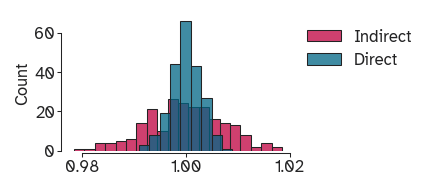

In [55]:
plt.figure(figsize=TINY,dpi=150)
sns.histplot(indirect_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=RED,label = 'Indirect')
sns.histplot(direct_sender_receiver_ratio.values.flatten(),binwidth=0.002,color=DEEP_BLUE,label = 'Direct')
plt.legend(frameon=False,loc='upper left',bbox_to_anchor=(1, 1));
sns.despine(offset=1, trim=True);


In [56]:
indirect_sender_receiver_ratio.sort_values(0,ascending=False).head(10)

0
paracentral           1.017241
postcentral           1.017112
precentral            1.016310
medialorbitofrontal   1.016078
lateralorbitofrontal  1.015452
postcentral           1.015147
superiorfrontal       1.013691
postcentral           1.013140
paracentral           1.012467
precentral            1.012285

In [57]:
indirect_sender_receiver_ratio.sort_values(0,ascending=True).head(10)

0
superiortemporal  0.978493
precuneus         0.981835
bankssts          0.982807
parstriangularis  0.982941
lateraloccipital  0.984180
inferiorparietal  0.984400
postcentral       0.984668
lateraloccipital  0.985171
inferiortemporal  0.985733
temporalpole      0.985938

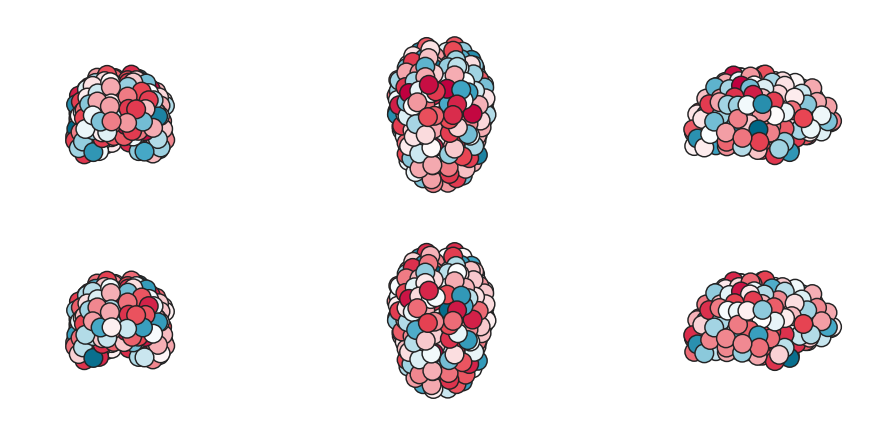

In [58]:
fig,axes = plt.subplot_mosaic([['A','B','C'],['D','E','F']],figsize=HALF_PAGE,subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['A'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['B'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(indirect_sender_receiver_ratio,coordinates,axes['C'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)

ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['D'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['E'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(direct_sender_receiver_ratio,coordinates,axes['F'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

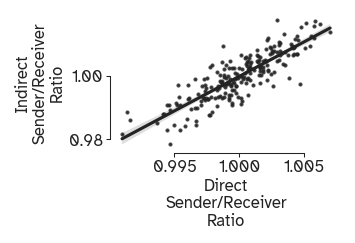

In [59]:
plt.figure(figsize=TINY,dpi=150)
sns.regplot(x=direct_sender_receiver_ratio,y=indirect_sender_receiver_ratio,fit_reg=True,color=HALF_BLACK,scatter_kws={'s':1})
plt.xlabel('Direct\nSender/Receiver\nRatio')
plt.ylabel('Indirect\nSender/Receiver\nRatio')
sns.despine(offset=1, trim=True);


In [60]:
influence_gradient = pd.DataFrame(ut.minmax_normalize(ut.threshold(5,indirect_influence).sum(0).values),index=labels)

In [61]:
region_desctiptions = scipy.io.loadmat('Simple-Brain-Plot-main/examples/regionDescriptions.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
correct_labels = region_desctiptions['regionDescriptions']['lausanne250']
hemispheres = consensus_mat['LauConsensus']['Matrices'][res_parcellation][4][:,3]


In [62]:
sorted_influence_gradient = ut.preprocess_for_surface_plot(influence_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_influence_gradient.mat', {'influence_gradient': sorted_influence_gradient.values})

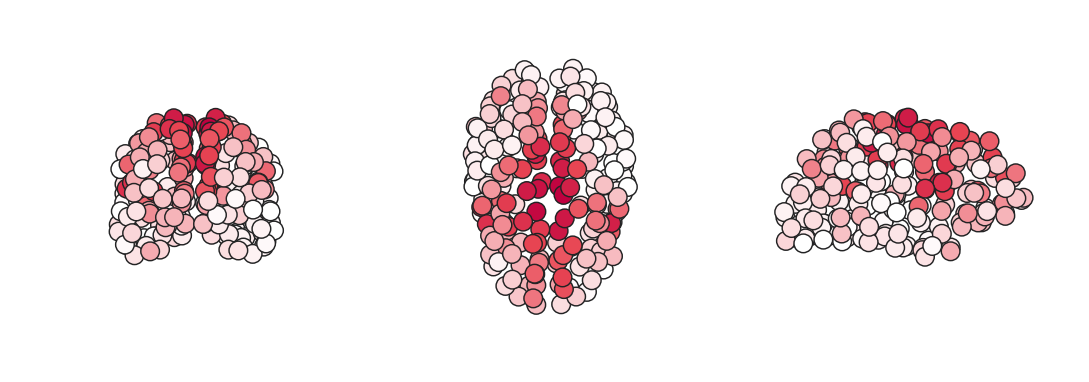

In [63]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=HALF_PAGE,subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_gradient,coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_gradient,coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)
#plt.savefig(f"causal_gradient.pdf",dpi=600,bbox_inches='tight')

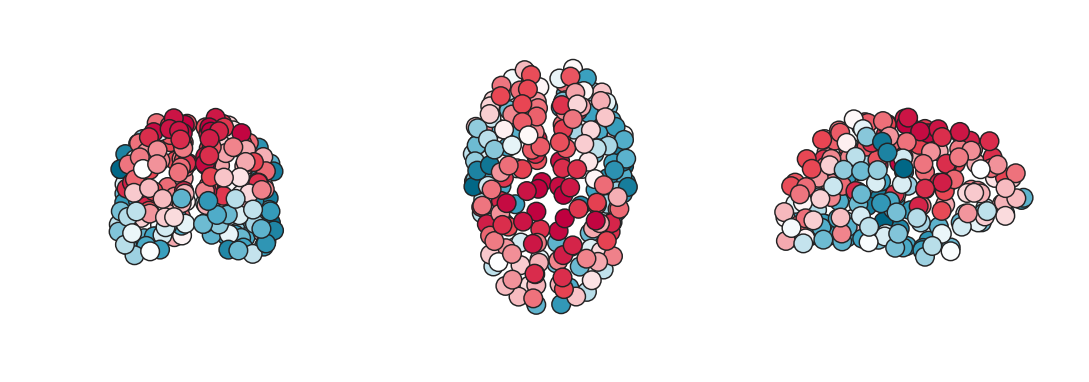

In [64]:
influence_zscore = scipy.stats.zscore(lognorm_ci.sum(axis=1))

fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=HALF_PAGE,subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(influence_zscore,coordinates,axes['A'],view=sagittal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_zscore,coordinates,axes['B'],view=axial,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)
ut.brain_plotter(influence_zscore,coordinates,axes['C'],view=coronal,size=size,cmap=diverge_from_white,scatter_kwargs=scatter_kw)

fig.tight_layout(pad=0.1)

In [65]:
influence_zscore_gradient = pd.DataFrame(influence_zscore,index=labels)

In [66]:
spearmanr(influence_gradient.values.flatten(),influence_zscore.flatten())

SignificanceResult(statistic=0.8314577262377973, pvalue=2.653763605239504e-57)

In [73]:
node_degrees = np.where(connectivity,1,0).sum(axis=0)

SignificanceResult(statistic=0.5127351494546262, pvalue=4.4127442108677503e-16)

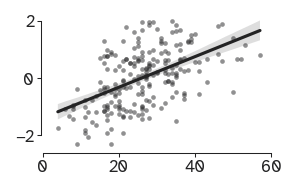

In [92]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(y=influence_zscore_gradient.values.flatten(),x=node_degrees.flatten(),s=5,linewidth=0,alpha=0.5,color=HALF_BLACK,rasterized=True)
sns.regplot(y=influence_zscore_gradient.values.flatten(),x=node_degrees.flatten(),scatter=False,color=HALF_BLACK)

plt.xlim(0,60)
sns.despine(offset=1, trim=True);

spearmanr(influence_zscore_gradient.values.flatten(),node_degrees.flatten())

SignificanceResult(statistic=0.9919739051949684, pvalue=7.041542838106002e-197)

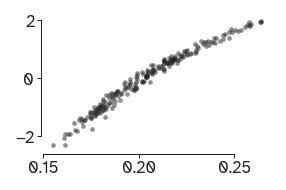

In [111]:
reachability_centrality = shortest_path_distance.mean(axis=0) # this is actually closeness centrality which I use nx to calculate later and the result are different so I gotta see what nx does!

plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(y=influence_zscore_gradient.values.flatten(),x=1/reachability_centrality.flatten(),s=5,linewidth=0,alpha=0.5,color=HALF_BLACK,rasterized=True)
#sns.regplot(y=influence_zscore_gradient.values.flatten(),x=reachability_centrality.flatten(),scatter=False,color=HALF_BLACK)

sns.despine(offset=1, trim=True);

spearmanr(influence_zscore_gradient.values.flatten(),1/reachability_centrality.flatten())

In [67]:
sorted_zscores = ut.preprocess_for_surface_plot(influence_zscore_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_zscore_gradient.mat', {'zscore': sorted_zscores.values})

In [65]:
influence_gradient.sort_values(0,ascending=False).head(10)

0
superiorfrontal          1.000000
posteriorcingulate       0.970621
superiorfrontal          0.939045
superiorfrontal          0.876307
caudalanteriorcingulate  0.839225
superiorfrontal          0.828736
paracentral              0.802146
superiorfrontal          0.799181
paracentral              0.796253
parsopercularis          0.773272

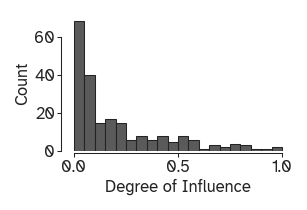

In [66]:
plt.figure(figsize=TINY,dpi=150)
sns.histplot(influence_gradient.values.flatten(),binwidth=0.05,color=HALF_BLACK)
plt.xlabel('Degree of Influence')
sns.despine(offset=1, trim=True);


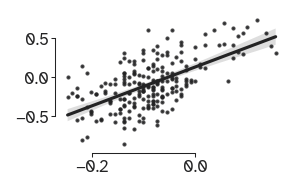

In [67]:
plt.figure(figsize=TINY,dpi=150)
sns.regplot(x=difference_outgoing,y=difference_incoming,fit_reg=True,color=HALF_BLACK,scatter_kws={'s':1})
sns.despine(offset=1, trim=True);


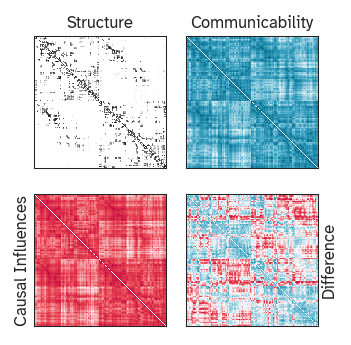

In [68]:
fig,axes = plt.subplot_mosaic([['A','CA'],
                               ['CI','DI']],figsize=(6*CM,6*CM),dpi=150)

sns.heatmap(lognorm_sc,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)
sns.heatmap(lognorm_comm,square=True,xticklabels=False,yticklabels=False,
            cmap=white_blue_mono,cbar=False,ax=axes['CA'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)

sns.heatmap(lognorm_ci,square=True,xticklabels=False,yticklabels=False,
            cmap=white_red_mono,cbar=False,ax=axes['CI'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)
sns.heatmap(difference,square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=diverge_from_white,cbar=False,ax=axes['DI'],linewidths=0, linecolor=HALF_BLACK,rasterized=True)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['CI'].set_ylabel("Causal Influences")
axes['DI'].set_ylabel("Difference")
axes['DI'].yaxis.set_label_position("right")
fig.tight_layout(pad=1)
#plt.savefig(f"figures/tanh_SC_CI_CO_diff.pdf",dpi=600,bbox_inches='tight')

In [69]:
direct_indirect_hue = indirect_influence.where(indirect_influence == 0, -1) + direct_influence.where(direct_influence == 0, 1)

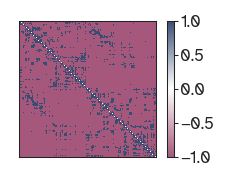

In [70]:
plt.figure(figsize=TINY,dpi=150)

sns.heatmap(direct_indirect_hue,square=True,xticklabels=False,yticklabels=False, 
            cmap=purples_diverge_from_white,linewidths=0, center=0, linecolor=HALF_BLACK)
sns.despine(top=False, right=False, left=False, bottom=False);

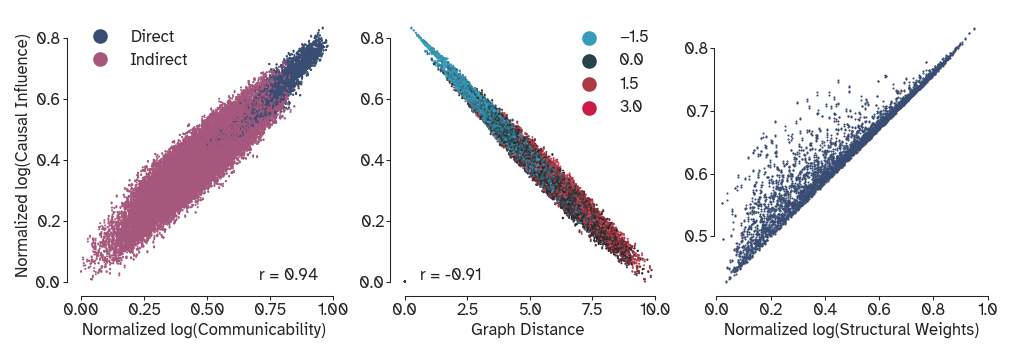

In [71]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=(17*CM,6*CM),dpi=150)
sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['A'],s=1,linewidth=0,rasterized=True)
sns.despine()

new_labels = ['Indirect','', 'Direct']
for i, text in enumerate(axes['A'].get_legend().get_texts()):
    text.set_text(new_labels[i])

sns.scatterplot(x=shortest_path_distance.flatten(),y=lognorm_ci.flatten(),ax=axes['B'],hue = difference.flatten(),
                palette=diverge_from_black, s=1,linewidth=0,rasterized=True)
sns.despine()

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],color=NIGHT_BLUE,ax=axes['C'],s=1,
                linewidth=0,rasterized=True)
sns.despine()

axes['A'].set_xlabel('Normalized log(Communicability)')
axes['A'].set_ylabel('Normalized log(Causal Influence)')
axes['B'].set_xlabel('Graph Distance')

axes['C'].set_xlabel('Normalized log(Structural Weights)')
fig.tight_layout(pad=1);

axes['A'].annotate(f"r = {round(pearsonr(lognorm_comm.flatten(),lognorm_ci.flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.7, 0.05), xycoords='axes fraction')
axes['B'].annotate(f"r = {round(pearsonr(shortest_path_distance.flatten(),lognorm_ci.flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.1, 0.05), xycoords='axes fraction')


handles = [plt.plot([], [], color=NIGHT_BLUE, marker='.',linestyle='', markersize=12, label='Direct')[0],
           plt.plot([], [], color=PURPLE, marker='.',linestyle='', markersize=12, label='Indirect')[0]]
axes['A'].legend(handles=handles, loc='upper left',frameon=False,fontsize=8)
axes['B'].legend(frameon=False,fontsize=8)
axes['C'].set_xlim(0,1)

axes['C'].legend().set_visible(False)
sns.despine(fig=fig,offset=1, trim=True);

#plt.savefig(f"figures/tanh_scatter_CI_GD_SC.pdf",dpi=600,bbox_inches='tight')

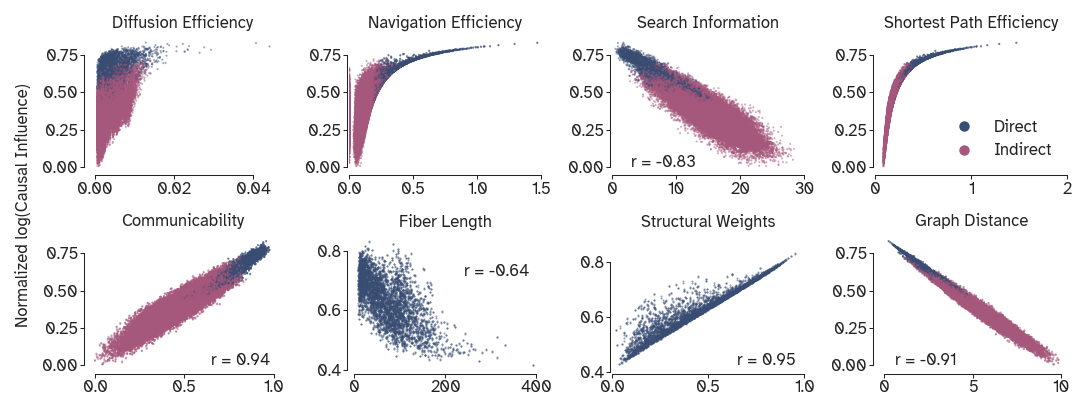

In [72]:
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H']],figsize=HALF_PAGE,dpi=150)

sns.scatterplot(x=diffusion_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['A'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=navigation_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['B'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=search_information.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['C'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=shortest_path_efficiency.values.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['D'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=lognorm_comm.flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,ax=axes['E'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=fiber_lengths[fiber_lengths!=0].flatten(),y=lognorm_ci[fiber_lengths!=0].flatten(),color=NIGHT_BLUE,ax=axes['F'],s=1,linewidth=0,alpha=0.5,rasterized=True)

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],color=NIGHT_BLUE,ax=axes['G'],s=1,linewidth=0,
                alpha=0.5,rasterized=True)

sns.scatterplot(x=shortest_path_distance.flatten(),y=lognorm_ci.flatten(),ax=axes['H'],hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,s=1,linewidth=0,alpha=0.5,rasterized=True)


axes['A'].set_title('Diffusion Efficiency',fontsize=8)
axes['B'].set_title('Navigation Efficiency',fontsize=8)
axes['C'].set_title('Search Information',fontsize=8)
axes['D'].set_title('Shortest Path Efficiency',fontsize=8)
axes['E'].set_title('Communicability',fontsize=8)
axes['F'].set_title('Fiber Length',fontsize=8)
axes['G'].set_title('Structural Weights',fontsize=8)
axes['H'].set_title('Graph Distance',fontsize=8)

for ax in ['A','B','C','E','H']:
    axes[ax].legend().remove()

axes['C'].annotate(f"r = {round(pearsonr(np.nan_to_num(search_information.values.flatten(),0),lognorm_ci.flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.1, 0.05), xycoords='axes fraction')

axes['E'].annotate(f"r = {round(pearsonr(lognorm_comm.flatten(),lognorm_ci.flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.65, 0.05), xycoords='axes fraction')

axes['F'].annotate(f"r = {round(pearsonr(fiber_lengths[fiber_lengths!=0].flatten(),lognorm_ci[fiber_lengths!=0].flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.6, 0.7), xycoords='axes fraction')

axes['G'].annotate(f"r = {round(pearsonr(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],direct_influence.values.flatten()[lognorm_sc.flatten()!=0])[0],2)}"
                   , color=HALF_BLACK, xy=(0.65, 0.05), xycoords='axes fraction')

axes['H'].annotate(f"r = {round(pearsonr(shortest_path_distance.flatten(),lognorm_ci.flatten())[0],2)}"
                   , color=HALF_BLACK, xy=(0.1, 0.05), xycoords='axes fraction')

fig.text(-0.01, 0.5, 'Normalized log(Causal Influence)', va='center', rotation='vertical',fontsize=8)

handles = [plt.plot([], [], color=NIGHT_BLUE, marker='.',linestyle='', markersize=8, label='Direct')[0],
           plt.plot([], [], color=PURPLE, marker='.',linestyle='', markersize=8, label='Indirect')[0]]
axes['D'].legend(handles=handles, loc='lower right',frameon=False,fontsize=8)

axes['B'].set_xlim(0,1.5)
axes['C'].set_xlim(0,30)
axes['D'].set_xlim(0,2)



axes['G'].set_ylim(0.4,0.9)
axes['G'].set_xlim(0,1)



sns.despine(fig=fig,offset=1, trim=True);
fig.tight_layout(pad=1);
#plt.savefig(f"figures/tanh_Communication_models_CI.pdf",dpi=600,bbox_inches='tight')

In [73]:
euclidean_distances = squareform(pdist(coordinates)).flatten()

In [74]:
sar_parameter_space = list(ParameterGrid({'omega':np.linspace(0.01,1.,20).round(2,)}))
for parameters in tqdm(sar_parameter_space,
                       total=len(sar_parameter_space),
                       desc='Optimizing hyperparams: '):
    fc = ut.sar_model(adjacency_matrix=connectivity, omega=parameters['omega'])
    sar = ut.log_minmax_normalize(fc)
    r = np.corrcoef(lognorm_ci.flatten(), sar.flatten())[0, 1]
    parameters.update({'correlation': r})


Optimizing hyperparams:   0%|          | 0/20 [00:00<?, ?it/s]

Optimizing hyperparams: 100%|██████████| 20/20 [00:01<00:00, 15.81it/s]


In [75]:
sar_optimum_params = max(sar_parameter_space, key=lambda x: x['correlation'])
sar_optimum_params

{'omega': 0.43, 'correlation': 0.9984295831058476}

In [76]:
sar = ut.sar_model(adjacency_matrix=connectivity, omega=0.27)
lognorm_sar = ut.log_minmax_normalize(sar)

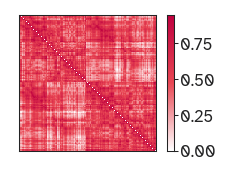

In [77]:
plt.figure(figsize=TINY,dpi=150)
sns.heatmap(ut.log_minmax_normalize(sar),square=True,xticklabels=False,yticklabels=False, 
            cmap=white_red_mono,linewidths=0, linecolor=HALF_BLACK,rasterized=True)

sns.despine(top=False, right=False, left=False, bottom=False);
#plt.savefig(f"figures/tanh_SAR_CI_fit_matrix.pdf",dpi=600,bbox_inches='tight')

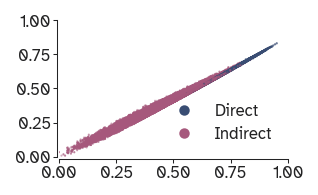

In [84]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(x=ut.log_minmax_normalize(sar).flatten(),y=lognorm_ci.flatten(),hue = direct_indirect_hue.values.flatten(),
                palette=purples_diverge_from_white,s=1,linewidth=0,alpha=0.5,rasterized=True)
plt.xlim(0,1)
plt.ylim(0,1)

sns.despine(offset=1, trim=True);
plt.legend(handles=handles, loc='lower right',frameon=False,fontsize=8);

In [81]:
X = pd.DataFrame({'diffusion_efficiency':diffusion_efficiency.values.flatten(),
                  'navigation_efficiency':navigation_efficiency.values.flatten(),
                  'search_information':search_information.values.flatten(),
                  'shortest_path_efficiency':shortest_path_efficiency.values.flatten(),
                  'communicability': lognorm_comm.flatten(),
                  'graph_distance':graph_distance.flatten(),
                  'structural_weight':lognorm_sc.flatten(),
                  'fiber_length':fiber_lengths.flatten(),
                  'fc':fc.flatten(),
                  'euclidean_distance': squareform(pdist(coordinates)).flatten(),
                  'sar':lognorm_sar.flatten()}).replace([np.inf, -np.inf], np.nan).fillna(0)
y = pd.DataFrame({'causal_influence':lognorm_ci.flatten()}).replace([np.inf, -np.inf], np.nan).fillna(0)

In [82]:
omegas = np.linspace(0.,1.,50).round(2,)
sars = np.zeros((connectivity.shape[0],connectivity.shape[0],len(omegas)))
for i, omega in enumerate(omegas):
    sar = ut.sar_model(adjacency_matrix=connectivity, omega=omega)
    lognorm_sar = ut.log_minmax_normalize(sar)
    sars[:,:,i] = lognorm_sar

In [83]:
n_trials=25
reg_contributions = np.zeros((n_trials,X.shape[1],len(omegas)))
scores=np.zeros((n_trials,len(omegas)))
for omega in range(len(omegas)):
    X['sar'] = sars[:,:,omega].flatten()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    for trial in tqdm(range(n_trials),desc='Lassoing like a boss',total=n_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED+trial, test_size=0.3, shuffle=True)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)

        lasso_model = LassoCV(cv=10, random_state=SEED,n_alphas=100,n_jobs=-1).fit(X_train, y_train)
        scores[trial,omega]=(lasso_model.score(X_test, y_test))
        reg_contributions[trial,:,omega] = (np.abs(lasso_model.coef_)/np.abs(lasso_model.coef_).sum())*100

Lassoing like a boss: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


In [84]:
reg_contributions_over_omega = pd.DataFrame(reg_contributions.mean(axis=0),index=X.columns,columns=omegas)
sorted_conts = reg_contributions_over_omega.loc[reg_contributions_over_omega.mean(axis=1).sort_values().index]

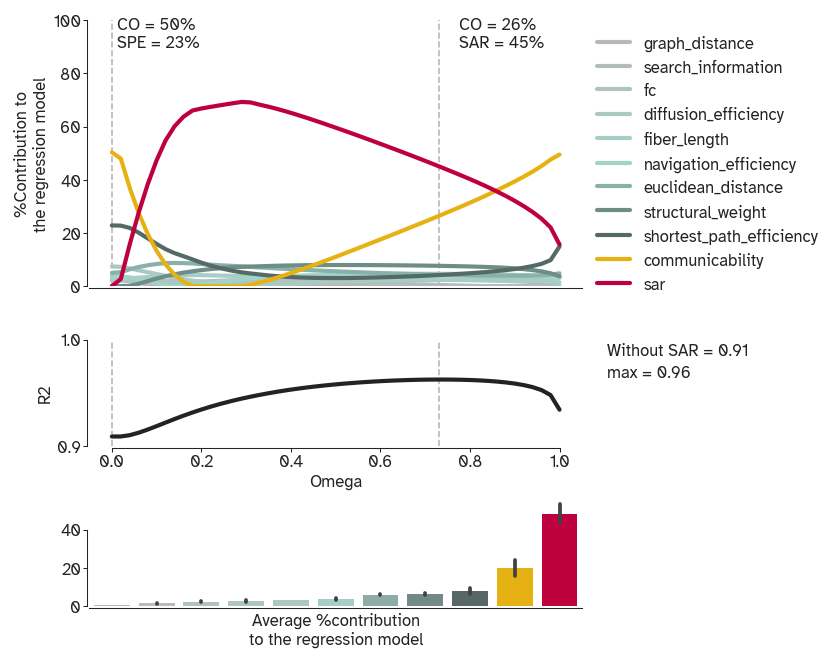

In [85]:
boring_map = sns.blend_palette([GRAY, SLOW_GREEN, HALF_BLACK], n_colors=sorted_conts.shape[0])
sorted_palette = [boring_map[i] for i in range(len(sorted_conts.index))]

fig,axes = plt.subplot_mosaic([['A','A','A','A'],
                               ['A','A','A','A'],
                               ['B','B','B','B'],
                               ['X','X','X','X']],figsize=(14*CM,11*CM),dpi=150)
axes['B'].axvline(omegas[np.argmax(scores.mean(axis=0))],color=GRAY,linestyle='--',linewidth=0.8)
axes['A'].axvline(omegas[np.argmax(scores.mean(axis=0))],color=GRAY,linestyle='--',linewidth=0.8)
axes['A'].axvline(0,color=GRAY,linestyle='--',linewidth=0.8)
axes['B'].axvline(0,color=GRAY,linestyle='--',linewidth=0.8)

for indx, contribution in enumerate(sorted_conts.index):
    if contribution == 'sar':
        axes['A'].plot(sorted_conts.loc[contribution],linewidth=2,label=contribution,color=RED)
    elif contribution == 'communicability':
        axes['A'].plot(sorted_conts.loc[contribution],linewidth=2,label=contribution,color=YELLOW)
    else:
        axes['A'].plot(sorted_conts.loc[contribution],linewidth=2,label=contribution,color=boring_map[indx])
        
axes['X'] = sns.barplot(data=sorted_conts.T,orient='v',palette=sorted_palette)
axes['X'].containers[0].get_children()[-1].set_facecolor(RED)
axes['X'].containers[0].get_children()[-2].set_facecolor(YELLOW)


axes['A'].set_xticks([])
axes['A'].legend(loc='lower center',bbox_to_anchor=(0.4, 0.12),frameon=False,fontsize=5)
sns.move_legend(axes['A'], "upper left", bbox_to_anchor=(1, 1))

axes['A'].set_ylabel('%Contribution to\nthe regression model')

axes['B'].plot(omegas,scores.mean(axis=0),HALF_BLACK,linewidth=2)

axes['B'].set_yticks([0.9,1.])
axes['B'].set_xticks(list(np.linspace(0,1,6)))

axes['B'].set_xlabel('Omega')
axes['B'].set_ylabel('R2')
axes['X'].set_xticks([])
axes['X'].set_xlabel('Average %contribution\nto the regression model')

axes['B'].annotate(f"max = {round(scores.mean(axis=0).max(),2)}"
                   ,color=HALF_BLACK, xy=(1.05, 0.65), xycoords='axes fraction')

axes['B'].annotate(f"Without SAR = {round(scores.mean(axis=0)[0],2)}"
                   ,color=HALF_BLACK, xy=(1.05, 0.85), xycoords='axes fraction')

optimal_comm_cont = round(sorted_conts[omegas[np.argmax(scores.mean(axis=0))]]['communicability'])
optimal_sar_cont = round(sorted_conts[omegas[np.argmax(scores.mean(axis=0))]]['sar'])

sarless_comm_cont = round(sorted_conts[0]['communicability'])
sarless_sp_cont = round(sorted_conts[0]['shortest_path_efficiency'])

axes['A'].annotate(f"CO = {sarless_comm_cont}%\nSPE = {sarless_sp_cont}%",
                   color=HALF_BLACK, xy=(0.055, 0.9), xycoords='axes fraction')

axes['A'].annotate(f"CO = {optimal_comm_cont}%\nSAR = {optimal_sar_cont}%"
                   ,color=HALF_BLACK, xy=(0.75, 0.9), xycoords='axes fraction')
axes['A'].set_ylim(0,100)


sns.despine(fig=fig,offset=1, trim=True);
fig.tight_layout(pad=0.5);
#plt.savefig(f"figures/tanh_multivariate_over_omega.pdf",dpi=600,bbox_inches='tight')

In [86]:
X_paths = {}
for path in range(14):
    w = np.linalg.matrix_power(connectivity,path+1)
    w = ut.minmax_normalize(ut.log_normalize(w))
    np.fill_diagonal(w,0.)
    w = np.where(w!=1,w,0)
    X_paths[path+1] = w.flatten()
X_paths = pd.DataFrame(X_paths).replace([np.inf, -np.inf], np.nan).fillna(0)
X_paths.shape

(47961, 14)

In [87]:
n_trials = 100

path_contributions = np.zeros((n_trials,X_paths.shape[1]))
path_scores=np.zeros((n_trials))
for trial in tqdm(range(n_trials),desc='Me? pff, nothing, just walking around',total=n_trials):
    X_train, X_test, y_train, y_test = train_test_split(X_paths, y, random_state=SEED+trial, test_size=0.3, shuffle=True)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    lasso_model = LassoCV(cv=10, random_state=SEED,n_alphas=100,n_jobs=-1).fit(X_train, y_train)
    path_scores[trial]=(lasso_model.score(X_test, y_test))
    path_contributions[trial,:] = (np.abs(lasso_model.coef_)/np.abs(lasso_model.coef_).sum())*100

Me? pff, nothing, just walking around: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


In [88]:
X_paths = {}
for path in range(14):
    if path == 0:
        X_paths[path] = connectivity.flatten()
    else:
        w = np.linalg.matrix_power(connectivity,path)
        w = ut.minmax_normalize(ut.log_normalize(w))
        np.fill_diagonal(w,0.)
        w = np.where(w!=1,w,0)
        w = w/factorial(path)
        X_paths[path] = w.flatten()
X_paths = pd.DataFrame(X_paths).replace([np.inf, -np.inf], np.nan).fillna(0)
X_paths.shape

(47961, 14)

In [89]:
power_scores = np.zeros((X_paths.columns.shape[0],n_trials))
for trial in tqdm(range(n_trials),desc="(I'm Not Your) Steppin' Stone",total=n_trials):
    for step in X_paths.columns:
        if step == 0:
            X = X_paths.copy()[step].values.reshape(-1, 1)
        else:
            X += (X_paths[step].values).reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, lognorm_ci.flatten())
        power_scores[step,trial]=(linear_regressor.score(X, lognorm_ci.flatten()))


(I'm Not Your) Steppin' Stone: 100%|██████████| 100/100 [00:03<00:00, 32.94it/s]


In [90]:
power_score = pd.DataFrame(power_scores)

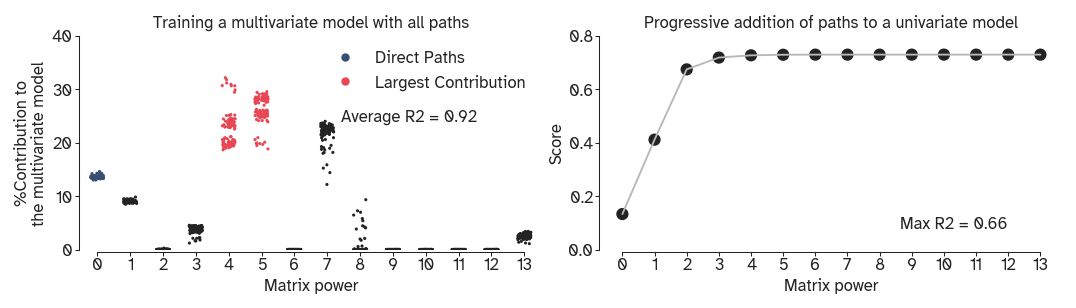

In [91]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(18*CM,5*CM),dpi=150)
dot_colors=[NIGHT_BLUE,HALF_BLACK,HALF_BLACK,HALF_BLACK,ORANGE,ORANGE,HALF_BLACK,HALF_BLACK,HALF_BLACK,HALF_BLACK,HALF_BLACK,HALF_BLACK,HALF_BLACK,HALF_BLACK]
sns.stripplot(data=path_contributions,palette=dot_colors,size=1.5,jitter=0.2,ax=axes['A'])
axes['A'].annotate(f"Average R2 = {round(path_scores.mean(),2)}",color=HALF_BLACK, xy=(0.565, 0.6), xycoords='axes fraction')
axes['B'].annotate(f"Max R2 = {round(power_score.mean().max(),2)}",color=HALF_BLACK, xy=(0.65, 0.1), xycoords='axes fraction')

axes['A'].set_xlabel('Matrix power')

axes['B'].set_xlabel('Matrix power')
axes['A'].set_ylabel('%Contribution to\nthe multivariate model')

sns.pointplot(data=power_score.T,ax=axes['B'],color=HALF_BLACK,join=False)
sns.pointplot(data=power_score.T,ax=axes['B'],color=GRAY,markers='',scale=0.5)

axes['B'].set_ylabel('Score')
axes['B'].set_title('Progressive addition of paths to a univariate model')
axes['A'].set_title('Training a multivariate model with all paths')


handles = [plt.plot([], [], color=NIGHT_BLUE, marker='.',linestyle='', markersize=6, label='Direct Paths')[0],
           plt.plot([], [], color=ORANGE, marker='.',linestyle='', markersize=6, label='Largest Contribution')[0]]
axes['A'].legend(handles=handles, loc='upper right',frameon=False,fontsize=8)
axes['A'].set_ylim(0,40)
axes['B'].set_ylim(0,0.8)
sns.despine(fig=fig,offset=1, trim=True);
plt.tight_layout(pad=0.5)
#plt.savefig(f"figures/tanh_step_uni_multivariate.pdf",dpi=600,bbox_inches='tight')

In [86]:
linear_regressor = LinearRegression()
linear_regressor.fit(lognorm_sc.flatten()[lognorm_sc.flatten()!=0].reshape(-1, 1), direct_influence.values.flatten()[lognorm_sc.flatten()!=0])
Y_pred = linear_regressor.predict(lognorm_sc.flatten()[lognorm_sc.flatten()!=0].reshape(-1, 1))
residuals = direct_influence.values.flatten()[lognorm_sc.flatten()!=0] - Y_pred

In [87]:
residual_matrix = lognorm_sc.copy()
residual_matrix[residual_matrix!=0] = residuals

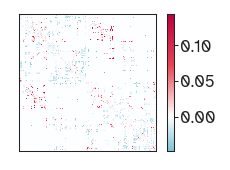

In [88]:
plt.figure(figsize=TINY,dpi=150)
sns.heatmap(residual_matrix,square=True,xticklabels=False,yticklabels=False,
            cmap=diverge_from_white,linewidths=0, linecolor=HALF_BLACK,center=0,rasterized=True)
sns.despine(top=False, right=False, left=False, bottom=False)
#plt.savefig(f"figures/tanh_residual_matrix.pdf",dpi=600,bbox_inches='tight')

In [89]:
ut.check_symmetric(residual_matrix)

False

In [90]:
vcenter = 0
vmin, vmax = residuals.min(), residuals.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)

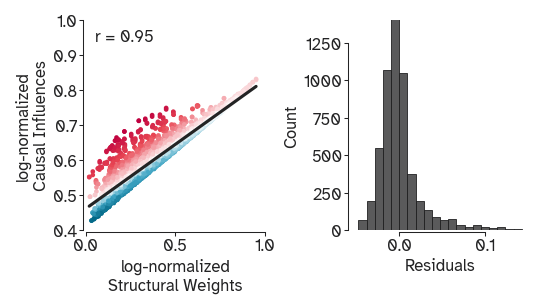

In [95]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=SMALL,dpi=150)

sns.scatterplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],
                hue=residual_matrix.flatten()[lognorm_sc.flatten()!=0],palette=diverge_from_white,s=5, hue_norm=normalize,linewidth=0,ax=axes['A'],rasterized=True)
sns.regplot(x=lognorm_sc.flatten()[lognorm_sc.flatten()!=0],y=direct_influence.values.flatten()[lognorm_sc.flatten()!=0],scatter=False,color=HALF_BLACK,ax=axes['A']);

sns.histplot(residuals,bins=20,color=HALF_BLACK,ax=axes['B'])

axes['A'].set_ylabel('log-normalized\nCausal Influences',fontsize=8)
axes['A'].set_xlabel('log-normalized\nStructural Weights',fontsize=8)
axes['B'].set_xlabel('Residuals',fontsize=8)

axes['A'].annotate(f"r = {round(pearsonr(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],direct_influence.values.flatten()[lognorm_sc.flatten()!=0])[0],2)}"
                   , color=HALF_BLACK, xy=(0.05, 0.9), xycoords='axes fraction',fontsize=8)
axes['A'].legend(frameon=False)
axes['A'].set_ylim(0.4,1)
axes['A'].set_xlim(0.,1)
axes['B'].set_ylim(0,1400)
axes['A'].legend().remove()

sns.despine(fig=fig,offset=1, trim=True);

fig.tight_layout(pad=0.5);
#plt.savefig(f"figures/tanh_residual_scatter.pdf",dpi=600,bbox_inches='tight')

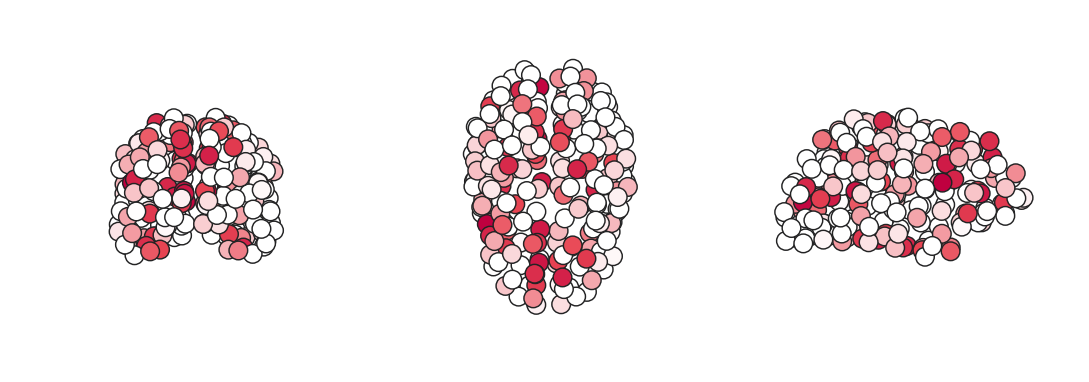

In [98]:
fig,axes = plt.subplot_mosaic([['A','B','C']],figsize=HALF_PAGE,subplot_kw=dict(projection='3d'),dpi=150)

ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['A'],view=sagittal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['B'],view=axial,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
ut.brain_plotter(np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None),coordinates,axes['C'],view=coronal,size=size,cmap=white_red_mono,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=0.1)

In [99]:
residual_gradient = pd.DataFrame(residual_matrix.sum(axis=0),index=labels)

In [100]:
sorted_residuals = ut.preprocess_for_surface_plot(residual_gradient,hemispheres,correct_labels)
scipy.io.savemat('hopf_residual_gradient.mat', {'residual_gradient': sorted_residuals.values})

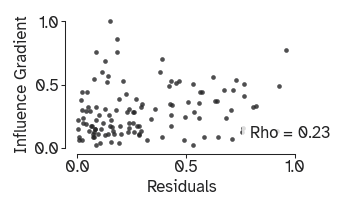

In [101]:
plt.figure(figsize=TINY,dpi=150)
positive_residuals = np.clip(residual_matrix.sum(axis=0),a_min=0,a_max=None)
sns.scatterplot(x=positive_residuals[positive_residuals!=0],y=influence_gradient.values.squeeze()[positive_residuals!=0],color=HALF_BLACK,s=5,linewidth=0,alpha=0.8)
plt.xlabel('Residuals',fontsize=8)
plt.ylabel('Influence Gradient',fontsize=8);
ig_vs_res = spearmanr(positive_residuals[positive_residuals!=0],influence_gradient.values.squeeze()[positive_residuals!=0])[0]
plt.annotate(f"Rho = {round(ig_vs_res,2)}",
             color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             xy=(0.8, 0.1), xycoords='axes fraction',fontsize=8)
sns.despine(offset=1, trim=True);
#plt.savefig(f"figures/tanh_residual_vs_influence_gradient.pdf",dpi=600,bbox_inches='tight')

In [102]:
spearmanr(positive_residuals[positive_residuals!=0],influence_gradient.values.squeeze()[positive_residuals!=0])

SignificanceResult(statistic=0.23083606323885492, pvalue=0.01154504539446089)

In [103]:
G = nx.from_numpy_array(connectivity)
communicability_binarized = communicability_bin(np.where(connectivity > 0, 1, 0))

In [104]:
closeness_c = list(nx.closeness_centrality(G).values())
betweenness_c = list(nx.betweenness_centrality(G).values())
degree_c = list(nx.degree_centrality(G).values())
eigen_vector_c = list(nx.eigenvector_centrality(G).values())
second_order_c = list(nx.second_order_centrality(G).values())
communicability_c = ut.communicability_centrality(connectivity)

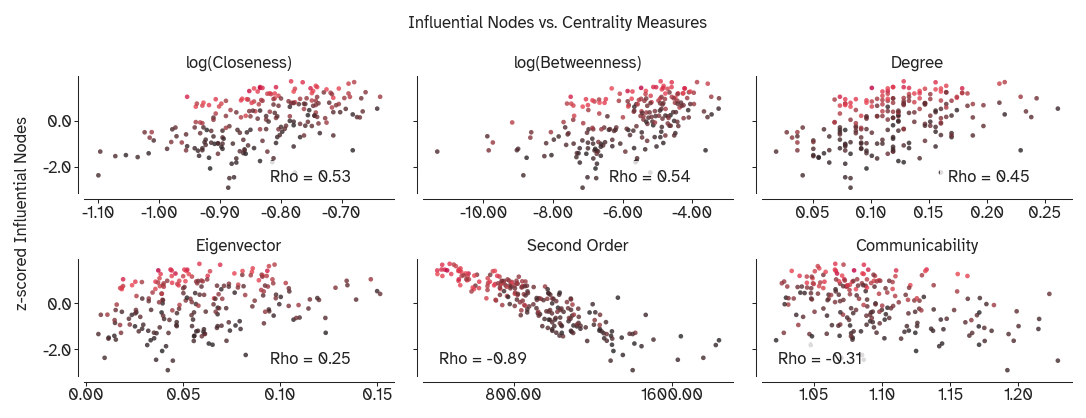

In [105]:
fig,axes = plt.subplot_mosaic([['A','B','C'],
                               ['D','E','F']],figsize=HALF_PAGE,dpi=150)

sns.scatterplot(x=ut.log_normalize(closeness_c),y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['A'],s=5,linewidth=0,alpha=0.8,rasterized=True)
axes['A'].set_title('log(Closeness)',fontsize=8)

sns.despine()

sns.scatterplot(x=ut.log_normalize(betweenness_c),y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['B'],s=5,linewidth=0,alpha=0.8,rasterized=True)

axes['B'].set_title('log(Betweenness)',fontsize=8, )
sns.despine()

sns.scatterplot(x=degree_c,y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['C'],s=5,linewidth=0,alpha=0.8,rasterized=True)
axes['C'].set_title('Degree',fontsize=8)
sns.despine()

sns.scatterplot(x=eigen_vector_c,y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['D'],s=5,linewidth=0,alpha=0.8,rasterized=True)
axes['D'].set_title('Eigenvector',fontsize=8)
sns.despine()

sns.scatterplot(x=second_order_c,y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['E'],s=5,linewidth=0,alpha=0.8,rasterized=True)
axes['E'].set_title('Second Order',fontsize=8)
sns.despine()

sns.scatterplot(x=communicability_c,y=influence_zscore,hue=influence_gradient.squeeze(),palette=black_red_mono,ax=axes['F'],s=5,linewidth=0,alpha=0.8,rasterized=True)
axes['F'].set_title('Communicability',fontsize=8)
sns.despine()


axes['A'].annotate(f"Rho = {round(spearmanr(ut.log_normalize(closeness_c),influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.6, 0.1), xycoords='axes fraction')

axes['B'].annotate(f"Rho = {round(spearmanr(ut.log_normalize(betweenness_c),influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.6, 0.1), xycoords='axes fraction')

axes['C'].annotate(f"Rho = {round(spearmanr(degree_c,influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.6, 0.1), xycoords='axes fraction')

axes['D'].annotate(f"Rho = {round(spearmanr(eigen_vector_c,influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.6, 0.1), xycoords='axes fraction')

axes['E'].annotate(f"Rho = {round(spearmanr(second_order_c,influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.05, 0.1), xycoords='axes fraction')

axes['F'].annotate(f"Rho = {round(spearmanr(communicability_c,influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.05, 0.1), xycoords='axes fraction')

for ax in ['A','B','C','D','E','F']:
    axes[ax].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    axes[ax].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axes[ax].legend().remove()

axes['E'].xaxis.set_major_locator(ticker.MaxNLocator(2))
for ax in ['B', 'C', 'E','F']:
    axes[ax].set_yticklabels([])
fig.text(-0.01, 0.5, 'z-scored Influential Nodes', va='center', rotation='vertical',fontsize=8)

fig.suptitle('Influential Nodes vs. Centrality Measures',fontsize=8)

sns.despine(fig=fig,offset=3, trim=False);
fig.tight_layout(pad=1);
#plt.savefig(f"figures/tanh_CI_centralities.pdf",dpi=600,bbox_inches='tight')

In [106]:
from nctpy.metrics import ave_control
from nctpy.utils import matrix_normalization
a_norm = matrix_normalization(consensus_mat['LauConsensus']['Matrices'][res_parcellation][0], system='discrete')
average_controllability = ave_control(connectivity, system='discrete')

SignificanceResult(statistic=0.884730426039965, pvalue=7.0216077922802166e-74)


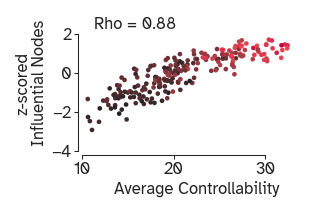

In [107]:
plt.figure(figsize=TINY,dpi=150)
sns.scatterplot(x=ut.log_normalize(average_controllability),y=influence_zscore,s=5,hue=influence_gradient.squeeze(),palette=black_red_mono,linewidth=0)
plt.legend().remove()
sns.despine()
plt.xlabel('Average Controllability')
plt.ylabel('z-scored\nInfluential Nodes')
plt.annotate(f"Rho = {round(spearmanr(ut.log_normalize(average_controllability),influence_zscore)[0],2)}",
               fontsize=8, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               xy=(0.05, 0.9), xycoords='axes fraction')
plt.ylim(-4,3)
plt.xlim(10,35)

sns.despine(offset=2, trim=True);
print(spearmanr(ut.log_normalize(average_controllability),influence_zscore))


In [108]:
if HOPF:
    sc_ci_coupling = np.zeros(sliced_modes.shape[1])
    comm_ci_coupling = np.zeros_like(sc_ci_coupling)
    gd_ci_coupling = np.zeros_like(sc_ci_coupling)

    indirect_power = np.zeros_like(sc_ci_coupling)
    direct_power = np.zeros_like(sc_ci_coupling)


    for timepoint in range(sliced_modes.shape[1]):
        lognorm_slice = ut.log_minmax_normalize(sliced_modes[:,timepoint,:])
        
        indirect_power[timepoint] = np.sum(lognorm_slice.flatten()[lognorm_sc.flatten()==0],axis=0)
        direct_power[timepoint] = np.sum(lognorm_slice.flatten()[lognorm_sc.flatten()!=0],axis=0)
        
        sc_ci_coupling[timepoint] = cosine(lognorm_sc.flatten()[lognorm_sc.flatten()!=0],lognorm_slice.flatten()[lognorm_sc.flatten()!=0])
        comm_ci_coupling[timepoint] = cosine(lognorm_comm.flatten(),lognorm_slice.flatten())
        gd_ci_coupling[timepoint] = cosine(shortest_path_distance.flatten()[lognorm_sc.flatten()==0],lognorm_slice.flatten()[lognorm_sc.flatten()==0])

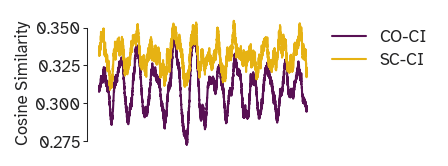

In [109]:
if HOPF:
    plt.figure(figsize=TINY,dpi=150)
    plt.plot(comm_ci_coupling,PURPLER)
    plt.plot(sc_ci_coupling,YELLOW)
    plt.ylabel('Cosine Similarity')
    plt.xticks([])
    plt.legend(['CO-CI','SC-CI'],fontsize=8,bbox_to_anchor=(1,1),frameon=False)

    sns.despine(offset=1, trim=True,bottom=True);
    plt.savefig(f"figures/HOPF_CI_sc_coupling.pdf",dpi=600,bbox_inches='tight')

In [110]:
if HOPF:
    smoothed_normalized_direct_power = ut.minmax_normalize(pd.DataFrame(direct_power).rolling(20).mean())
    smoothed_normalized_indirect_power = ut.minmax_normalize(pd.DataFrame(indirect_power).rolling(20).mean())

PearsonRResult(statistic=0.7939245285859241, pvalue=0.0)


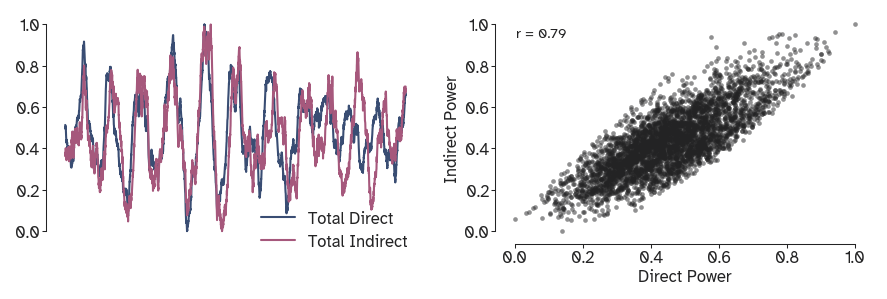

In [111]:
if HOPF:
    fig,axes = plt.subplot_mosaic([['A','B']],figsize=(18*CM,5*CM),dpi=150)
    axes['A'].plot(smoothed_normalized_direct_power,color=NIGHT_BLUE)
    axes['A'].plot(smoothed_normalized_indirect_power,color=PURPLE)
    sns.despine()
    sns.scatterplot(x=ut.minmax_normalize(direct_power),y=ut.minmax_normalize(indirect_power),s=5,alpha=0.5,color=HALF_BLACK,linewidth=0,ax=axes['B'],rasterized=True)
    axes['B'].set_xlabel('Direct Power')
    axes['B'].set_ylabel('Indirect Power')

    axes['B'].annotate(f"r = {round(pearsonr(direct_power,indirect_power)[0],2)}",
                fontsize=7, color=HALF_BLACK,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
                xy=(0.05, 0.9), xycoords='axes fraction')

    axes['A'].set_xticks([])
    sns.despine(ax=axes['A'],offset=1, trim=True,bottom=True);
    sns.despine(ax=axes['B'],offset=1, trim=True);
    axes['A'].legend(['Total Direct','Total Indirect'],fontsize=8,loc='lower right',bbox_to_anchor=(1,-0.1),frameon=False)

    print(pearsonr(direct_power,indirect_power))
    plt.savefig(f"figures/HOPF_CI_over_time.pdf",dpi=600,bbox_inches='tight')